## Import Tools 

In [2]:
#Initial load
from RedDownloader import RedDownloader
import praw
import requests
import re
import os
import urllib.request
from PIL import Image
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import sys
import sklearn
from torchvision import datasets, transforms, utils
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score, train_test_split
from scipy.stats import uniform
import random



### Set up Reddit credentials

In [ ]:
reddit = praw.Reddit(
    client_id = "qK4Xv6veQzln_8kyWjqbSw",
    client_secret = "bvzcM1BI3Lv3vWAj4UmWU2GNjs1VIw",
    username = "AllHailAI",
    password = "ChrisSebChris",
    user_agent = "Test"
)

subreddit = reddit.subreddit('EarthPorn')
top = subreddit.top()




In [ ]:
## Iterate through top pictures in subreddit. Can't download pictures from deleted accounts. Those are skipped
n_pictures = 200

submission_ids = []
upvote_ratio = []
upvote = []
channels = []

for submission in subreddit.top(limit = n_pictures):
    if submission.url.endswith('.jpg') or submission.url.endswith('.png'):

        try:
            urllib.request.urlretrieve(submission.url, "./Data/{filename}".format(filename = f"{submission.id}.{submission.url.split('.')[-1]}"))
            img = Image.open("./Data/{filename}.jpg".format(filename = submission.id))
            img = img.resize((224,224))

            img.save("./Data/{filename}.jpg".format(filename = submission.id))

            submission_ids.append(submission.id)
            upvote_ratio.append(submission.upvote_ratio)
            upvote.append(submission.score)
            channels.append(len(img.getbands()))

        except:
            pass

In [ ]:
df = pd.DataFrame({'submission_id':submission_ids, "upvote_ratio":upvote_ratio, "upvote": upvote, "channels":channels})

print(df.head())

In [2]:
random.seed(420)

# Normalize to mean and std of ImageNet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  
    ]
)


### Define CNN for classification

In [45]:

#Define CNN
learning_rate = 1e-4
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

    
    #Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)

    #Define pooling layers
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride = 2)


    #Define fully connected layers
        self.fc1 = nn.Linear(128*28*28,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,1)

    #Dropout some neurons to prevent overfitting.
        self.dropout = nn.Dropout(0.5)

    #Define activation functions
        self.relu = nn.ReLU()
        self.identity = nn.Identity()


#Apply convolutional layers with pooling in between
    def forward(self, x):
        feature_map = []
        x = self.max_pool(nn.functional.relu(self.conv1(x)))
        feature_map.append(x)
        x = self.max_pool(nn.functional.relu(self.conv2(x)))
        feature_map.append(x)
        x = self.max_pool(nn.functional.relu(self.conv3(x)))
        feature_map.append(x)

#Flatten output
        x = x.view(-1, 128*28*28)

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.identity(self.fc3(x))

        return feature_map, x

model = Model()
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (identity): Identity()
)


### Load data 

In [11]:
data_path = 'C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/RedditDataWithLinks4.csv'
posts_tidy_df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
posts_tidy_df

,Subreddit,SubredditID,PostTitle,PostID,TimeString,PostTime,Username,ViewCount,Upvotes,Ups,Downs,UpvoteRatio,CommentNumber,Edited,ImageDomain,ImageURL,Permalink,IsTextPost,PostText,SelfTextHTML,UserCreatedTime,AuthorName,Distinguished,LinkFlairClass,LinkFlairText,AuthorBirthdate,IsVideo,IsMeta,IsOriginal,IsRedditMediaDomain,IsCrosspostable,CrosspostsNumber,CrosspostParent,CrosspostParentList,SubRedditSubscribers,OnlyMedia,EmbeddedMedia,SecureEmbeddedMedia,Media,SecureMedia,Thumbnail,Stickied,Archived,IsHideScore,Pinned,PostHint,Preview,CommentsLocked,NSFW,NewURL,ScaledUpvoteRatio,AppliedScale
0,EarthPorn,t5_2sbq3,"Kalsoy, Faroe Islands [2214x1548]",swun9,2012-04-28 15:32:12,1335627132,jonpacker,NaN,115,124.0,9.0,13.777778,2,False,i.imgur.com,http://i.imgur.com/x0PIq.jpg,/r/EarthPorn/comments/swun9/kalsoy_faroe_islan...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://e.thumbs.redditmedia.com/oCCuPAV58aNOHE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/x0PIq.jpg,0.234568,3.231824
1,EarthPorn,t5_2sbq3,The shimmering slopes of the pristine Austrian...,swtuj,2012-04-28 15:08:04,1335625684,kjoneslol,NaN,9,13.0,4.0,3.250000,0,False,flickr.com,http://www.flickr.com/photos/visbeek/677221493...,/r/EarthPorn/comments/swtuj/the_shimmering_slo...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://e.thumbs.redditmedia.com/pRiuG_KieSX9rF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,//live.staticflickr.com/7146/6772214933_a5d596...,0.067460,0.219246
2,EarthPorn,t5_2sbq3,"View from Val Thorens, France [5604x2082]",swqhw,2012-04-28 13:11:35,1335618695,vhs86,NaN,12,14.0,2.0,7.000000,3,False,imgur.com,http://imgur.com/KmyH8,/r/EarthPorn/comments/swqhw/view_from_val_thor...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://d.thumbs.redditmedia.com/ChEKCp4SEM8aZL...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/KmyH8.jpg,0.126984,0.888889
3,EarthPorn,t5_2sbq3,"Devetashka Cave, Bulgaria [1600x1071]",swq3t,2012-04-28 12:54:45,1335617685,Mind_Virus,NaN,1155,1950.0,795.0,2.452830,35,False,i.imgur.com,http://i.imgur.com/wPGUn.jpg,/r/EarthPorn/comments/swq3t/devetashka_cave_bu...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://d.thumbs.redditmedia.com/sZEkuz4BrWejGK...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/wPGUn.jpg,0.054807,0.134432
4,EarthPorn,t5_2sbq3,Salar de Atacama Highlands bordered by Laguna ...,swpww,2012-04-28 12:46:26,1335617186,[deleted],NaN,2,3.0,1.0,3.000000,0,False,flickr.com,http://www.flickr.com/photos/desertsky/2159774...,/r/EarthPorn/comments/swpww/salar_de_atacama_h...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,//live.staticflickr.com/2823/33143780524_a9402...,0.063492,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,EarthPorn,t5_2sbq3,Panoramic I made of the morning in our campsit...,ibfwg,2011-06-28 16:57:15,1309280235,thebigmann,NaN,147,231.0,84.0,2.750000,25,False,imgur.com,http://imgur.com/pZymh,/r/EarthPorn/comments/ibfwg/panoramic_i_made_o...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_ibfwg.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/pZymh.jpg,0.059524,0.163690
21654,EarthPorn,t5_2sbq3,A nice waterfall I photographed a few days ago...,ibfvz,2011-06-28 16:56:57,1309280217,marltu,NaN,119,169.0,50.0,3.380000,13,False,i.imgur.com,http://i.imgur.com/Yarr9.jpg,/r/EarthPorn/comments/ibfvz/a_nice_waterfall_i...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_ibfvz.png,NaN,NaN,NaN,NaN,NaN

In [40]:
print(min(posts_tidy_df['AppliedScale']))
print(max(posts_tidy_df['AppliedScale']))

-0.0
62.0


In [40]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

def ImageWithScore(img_path, csv):
    data_path = pd.read_csv(csv)
    transformed_images = []
    scores = []
    corrupted = []
    counter = 0

    for index, row in data_path.iterrows():
        if counter % 1000 == 0:
            print('Current progress is at: {count}'.format(count=counter))

        submission_id = row['PostID'] + ".jpg"
        score = np.log10(row['AppliedScale']) #Choose target here!!
        image_path = os.path.join(img_path, submission_id)
        image_path = os.path.join(image_path).replace("\\", "/")
        if os.path.exists(image_path):
            try:
                with Image.open(image_path) as image:
                    # Normalize to mean and std of ImageNet
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

                    transformed_image = transform(image)
                    transformed_images.append(transformed_image)
                    scores.append(score)
                    counter += 1
            except Exception as e:
                print(f'Image failed: {submission_id}: {e}')
                corrupted.append(submission_id)
                counter += 1
        else:
            print(f'Image not found: {image_path}')
            counter += 1

    return transformed_images, scores

image_path = "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3"
data_path = 'C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/RedditDataWithLinks4.csv'

transformed_images, scores = ImageWithScore(image_path, data_path)


Current progress is at: 0
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swphj.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swh4g.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw672.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw5ng.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtg5.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtbd.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svlbb.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svffq.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svf6n.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svc81.jpg
Image not found: C:/User

In [41]:
from sklearn.model_selection import train_test_split

# Split the images and scores into training and testing sets
train_images, test_images, train_scores, test_scores = train_test_split(transformed_images, scores, test_size=0.2, random_state=42)

# Create train_data and test_data
train_data = list(zip(train_images, train_scores))
test_data = list(zip(test_images, test_scores))


#### Sanity check to see if it is split correcltly

In [42]:
print(train_data[:1])

[(tensor([[[ 0.3652,  0.3652,  0.3481,  ..., -1.2445, -1.2274, -1.2617],
         [ 0.3652,  0.3652,  0.3481,  ..., -1.3473, -1.3644, -1.3644],
         [ 0.3652,  0.3652,  0.3481,  ..., -1.4500, -1.4672, -1.4672],
         ...,
         [-1.4500, -1.4672, -1.5014,  ..., -1.8610, -1.8439, -1.8439],
         [-1.4500, -1.4672, -1.5014,  ..., -1.8782, -1.8610, -1.8610],
         [-1.4843, -1.5014, -1.5357,  ..., -1.8953, -1.8782, -1.8782]],

        [[ 0.8179,  0.8179,  0.8004,  ..., -1.3880, -1.3704, -1.3704],
         [ 0.8179,  0.8179,  0.8004,  ..., -1.4930, -1.4755, -1.4755],
         [ 0.8179,  0.8179,  0.8004,  ..., -1.5980, -1.5805, -1.5455],
         ...,
         [-1.3529, -1.3704, -1.4055,  ..., -1.7731, -1.7556, -1.7556],
         [-1.3529, -1.3704, -1.4055,  ..., -1.7906, -1.7731, -1.7731],
         [-1.3880, -1.4055, -1.4405,  ..., -1.8081, -1.7906, -1.7906]],

        [[ 1.6640,  1.6640,  1.6465,  ..., -1.1596, -1.1421, -1.1421],
         [ 1.6640,  1.6640,  1.6465,  ..., 

#### DEBUG CNN WITH FEWER IMAGES

In [6]:
train_data = train_data[:200]
test_data = test_data[:200]

In [43]:
import torch
from torch.utils.data import Dataset

class Loader(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, score = self.data[index]
        return image, score



print(Loader(train_data)[0][1])


-1.0838014436843704


In [44]:
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

### Train CNN 

In [28]:
# Train loop
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

def CNN(learning_rate, batch_size, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for i, (images, score) in enumerate(train_loader):
            optimizer.zero_grad()

            if images.dim() == 3:
                images = torch.unsqueeze(images, dim=0)

            output = model(images.float())
            loss = criterion(output.float(), score.float()) 
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Test the model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                if data.dim() == 3:
                    data = torch.unsqueeze(data, dim=0)
                output = model(data)
                test_loss += criterion(output, target)

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, num_epochs, avg_train_loss, avg_test_loss))

    print("Finished training.")

    return model, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-3, batch_size=50, num_epochs=20)


KeyboardInterrupt: 

In [45]:
import torchvision.models as models

def CNN(learning_rate, batch_size, num_epochs):
    # Define the model
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, 1)
    
    # Move the model to the desired device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet.to(device)
    
    # Define the criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
    
    # Train the model
    resnet.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        
        for images, scores in train_loader:
            images = images.to(device)
            scores = scores.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = resnet(images)
            loss = criterion(outputs, scores.unsqueeze(1).float())
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate on the test set
        resnet.eval()
        total_test_loss = 0
        
        with torch.no_grad():
            for images, scores in test_loader:
                images = images.to(device)
                scores = scores.to(device)
                
                # Forward pass
                outputs = resnet(images)
                loss = criterion(outputs, scores.unsqueeze(1).float())
                
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    print("Finished training.")
    
    return resnet, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-3, batch_size=50, num_epochs=20)


Epoch [1/20], Train Loss: 0.3465, Test Loss: 0.3032
Epoch [2/20], Train Loss: 0.3532, Test Loss: 0.3151
Epoch [3/20], Train Loss: 0.3431, Test Loss: 0.3058
Epoch [4/20], Train Loss: 0.3367, Test Loss: 0.4366
Epoch [5/20], Train Loss: 0.3275, Test Loss: 0.3294
Epoch [6/20], Train Loss: 0.3328, Test Loss: 0.3179
Epoch [7/20], Train Loss: 0.3311, Test Loss: 0.3312
Epoch [8/20], Train Loss: 0.3259, Test Loss: 0.3741
Epoch [9/20], Train Loss: 0.3206, Test Loss: 0.3152
Epoch [10/20], Train Loss: 0.3286, Test Loss: 0.6186
Epoch [11/20], Train Loss: 0.3131, Test Loss: 0.4168
Epoch [12/20], Train Loss: 0.3194, Test Loss: 0.3191
Epoch [13/20], Train Loss: 0.3296, Test Loss: 0.4776
Epoch [14/20], Train Loss: 0.3237, Test Loss: 0.3221
Epoch [15/20], Train Loss: 0.3191, Test Loss: 0.3230
Epoch [16/20], Train Loss: 0.3195, Test Loss: 0.3131
Epoch [17/20], Train Loss: 0.3129, Test Loss: 0.4114
Epoch [18/20], Train Loss: 0.3120, Test Loss: 0.3378
Epoch [19/20], Train Loss: 0.3203, Test Loss: 0.3952
Ep

In [46]:
torch.save(model.state_dict(), "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth")

#### Save model

In [15]:
torch.save(model.state_dict(), "C:/Users/Chris/Desktop/DTU/4. Semester/02466  Project Work/ModelAppliedScale.pth")-

In [17]:
train_scores = []
for images, scores in train_loader:
    train_scores.extend(scores.tolist())

mean_score = sum(train_scores) / len(train_scores)
print("Mean of train set scores:", mean_score)


Mean of train set scores: 0.748828338168509


In [62]:

train_scores = []
for images, scores in train_loader:
    train_scores.extend(scores.tolist())

median_score = np.median(train_scores)
print("Median of train set scores:", median_score)


Median of train set scores: 0.2591512795594428


#### Load model (if already trained previously)

#### Predict scores (Our own)

In [90]:
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader


# Load the trained model
model = Model()
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/ResNet50b20elr3.pth"))
model.to(device)
model.eval()

# Make predictions on the test data
predicted_scores = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data.float())
        predicted_scores.extend(output.squeeze().cpu().numpy())

# The predicted_scores list will contain the predicted scores for the test images


NameError: name 'Model' is not defined

#### Predict scores (ResNet)

In [48]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)

# Modify the final layer to output a single score
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Load the weights from the checkpoint
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth"))

# Set the device and mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Make predictions on the test data
predicted_scores = []
with torch.no_grad():
    for images, scores in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted_scores.extend(outputs.squeeze().cpu().numpy())

# The predicted_scores list will contain the predicted scores for the test images


#### Feature map

In [86]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/ResNet50b20elr3.pth"))
model.to(device)
model.eval()

# Make predictions on the test data
predicted_scores = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        feature_map, output = model(data.float())
        predicted_scores.extend(output.squeeze().cpu().numpy())

# The predicted_scores list will contain the predicted scores for the test images


NameError: name 'Model' is not defined

#### Feature Map (ResNet)

In [52]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)

# Remove the final layer (fully connected layer)
model = nn.Sequential(*list(model.children())[:-1])

# Load the weights from the checkpoint
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth"), strict=False)


# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Initialize a list to store the feature maps
feature_maps = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        feature_maps.extend(outputs.cpu().numpy())

# The feature_maps list will contain the feature maps for the test images


In [59]:
import torchvision.models as models

def feature_extraction(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    features = []
    labels = []
    
    with torch.no_grad():
        for images, scores in data_loader:
            images = images.to(device)
            
            # Forward pass until the last layer before the modified final layer
            features_batch = model.conv1(images)
            features_batch = model.bn1(features_batch)
            features_batch = model.relu(features_batch)
            features_batch = model.maxpool(features_batch)

            features_batch = model.layer1(features_batch)
            features_batch = model.layer2(features_batch)
            features_batch = model.layer3(features_batch)
            features_batch = model.layer4(features_batch)
            
            features.append(features_batch)
            labels.append(scores)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels

# Instantiate a new ResNet model
resnet = models.resnet50(pretrained=True)

# Load the saved state dictionary into the model
state_dict = torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth")

# Modify the state dictionary to match the modified final layer in your current model
state_dict['fc.weight'] = resnet.fc.weight
state_dict['fc.bias'] = resnet.fc.bias

# Load the modified state dictionary into the model
resnet.load_state_dict(state_dict)



<All keys matched successfully>

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torchvision.models as models

def feature_extraction(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    features = []
    labels = []
    
    with torch.no_grad():
        for images, scores in data_loader:
            images = images.to(device)
            
            # Forward pass until the last layer (fully connected layer)
            features_batch = model(images)
            
            features.append(features_batch)
            labels.append(scores)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels


# Instantiate a new ResNet model
resnet = models.resnet50(pretrained=True)

# Load the saved state dictionary into the model
state_dict = torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth")

# Modify the state dictionary to match the modified final layer in your current model
state_dict['fc.weight'] = resnet.fc.weight
state_dict['fc.bias'] = resnet.fc.bias

# Load the modified state dictionary into the model
resnet.load_state_dict(state_dict)



# Instantiate a new ResNet model
resnet = models.resnet50(pretrained=True)

# Load the saved state dictionary into the model
state_dict = torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth")

# Modify the state dictionary to match the modified final layer in your current model
state_dict['fc.weight'] = resnet.fc.weight
state_dict['fc.bias'] = resnet.fc.bias

# Load the modified state dictionary into the model
resnet.load_state_dict(state_dict)

# Assuming you have your train_loader defined

# Extract features from the train set
train_features, train_labels = feature_extraction(resnet, train_loader)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features.cpu().numpy())

# Create a scatter plot of the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Feature Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


KeyboardInterrupt: 

#### Filter visualisation

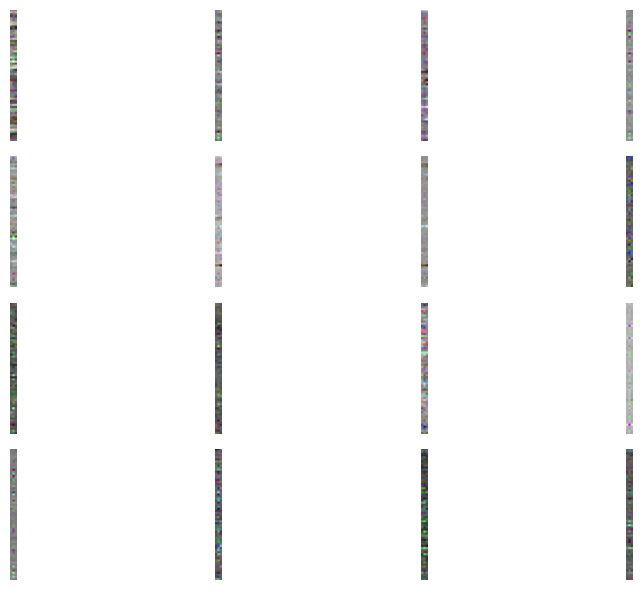

In [85]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(model, layer_name, num_filters=16, figsize=(10, 6)):
    # Get the weights of the specified layer
    filters = model.state_dict()[layer_name + '.weight'].cpu().detach().numpy()

    # Select a subset of filters to visualize
    filters = filters[:num_filters]

    # Calculate the number of rows and columns for subplots
    num_rows = int(np.sqrt(num_filters))
    num_cols = int(np.ceil(num_filters / num_rows))

    # Create the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Iterate over the filters and plot them
    for i, ax in enumerate(axes.flatten()):
        if i < num_filters:
            # Get the i-th filter
            filter_i = filters[i]

            # Check the shape of the filter
            if len(filter_i.shape) == 4:
                # Transpose and reshape the filter for visualization
                filter_i = filter_i.transpose((3, 2, 0, 1))
                filter_i = filter_i.reshape(-1, filter_i.shape[2], filter_i.shape[3])
            elif len(filter_i.shape) == 2:
                # Reshape the filter for visualization
                filter_i = filter_i.reshape(-1, filter_i.shape[0], filter_i.shape[1])

            # Normalize the filter weights to the range [0, 1]
            filter_i = (filter_i - filter_i.min()) / (filter_i.max() - filter_i.min())

            # Plot the filter as an image
            ax.imshow(filter_i)

            ax.axis('off')
        else:
            ax.axis('off')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()





# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth", map_location=torch.device('cpu')))

# Visualize filters for the second convolutional layer
visualize_filters(model, 'layer1.0.conv2', num_filters=16)


#### Activation map

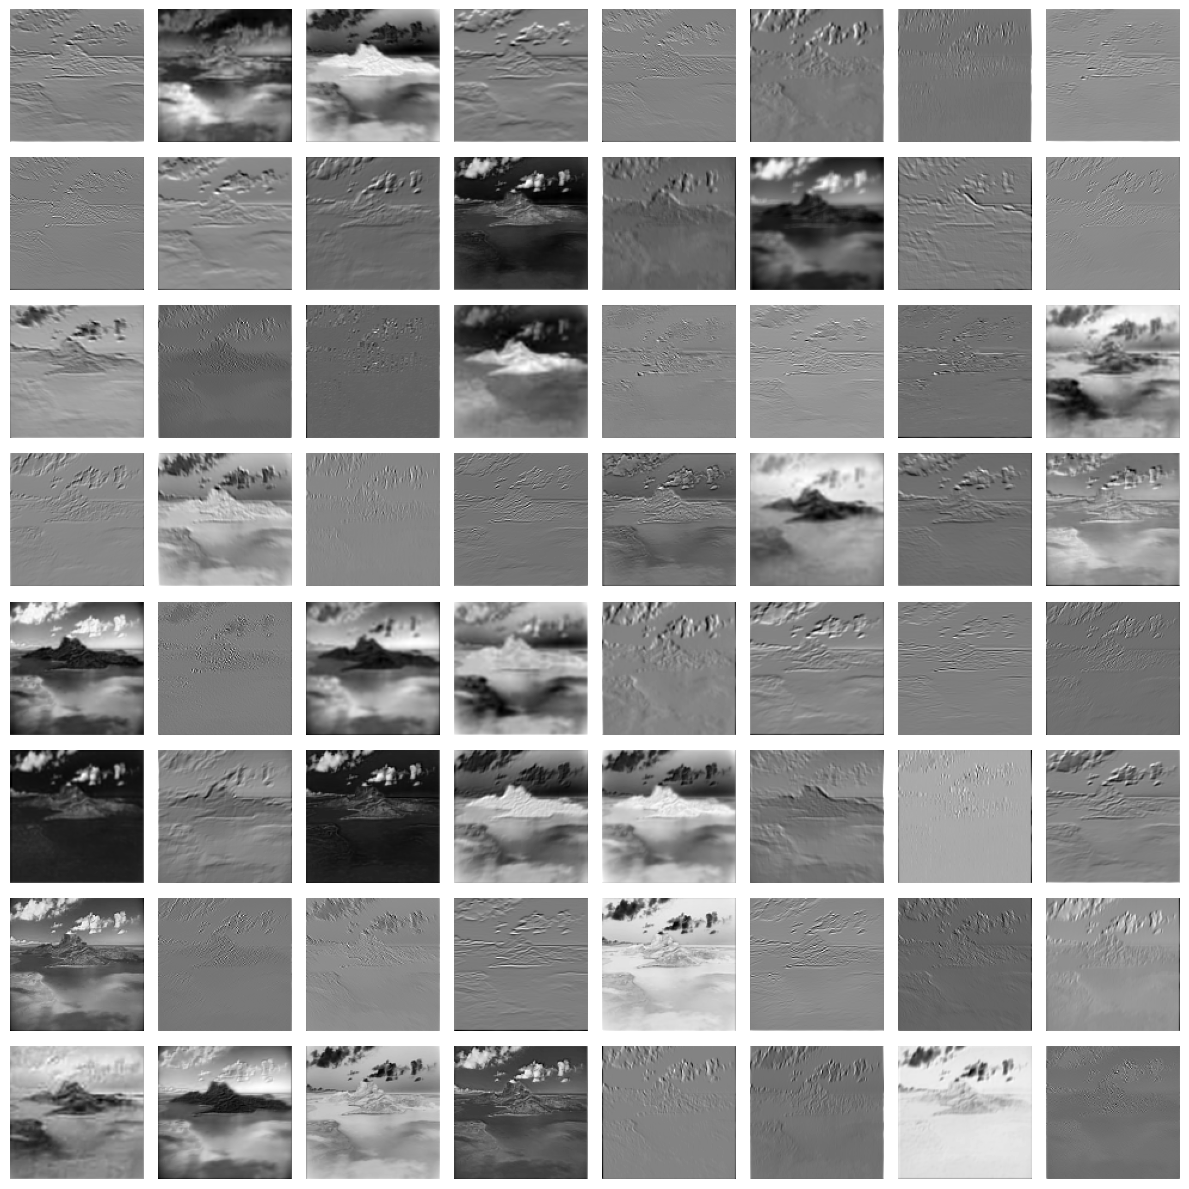

In [95]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
model = models.resnet50(pretrained=True)

# Choose an image for visualization
image_path = "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/fl0b5.jpg"
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# Move the model and input tensor to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_batch = input_batch.to(device)

# Forward pass to extract feature maps
model.eval()
with torch.no_grad():
    features = model.conv1(input_batch)  # Choose the desired layer for visualization

# Convert the feature maps to numpy array
activation_maps = features.squeeze(0).cpu().numpy()

# Visualize the activation maps
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(activation_maps[i], cmap = 'gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


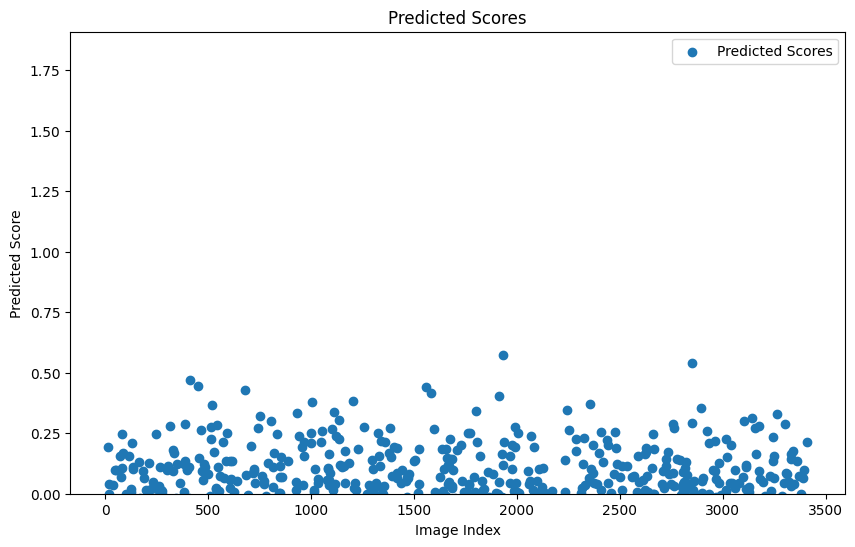

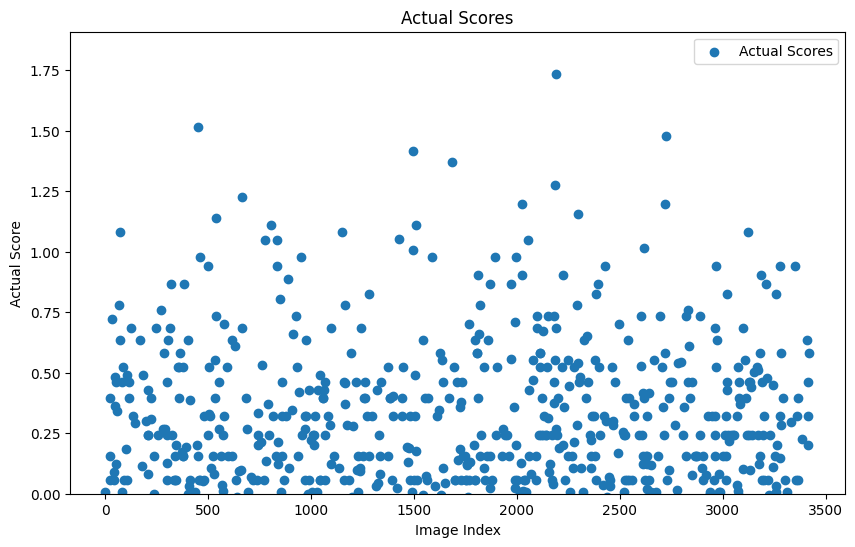

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the predicted_scores list to a numpy array
predicted_scores = np.array(predicted_scores)

# Convert the target scores to a numpy array
actual_scores = np.array(test_scores)

# Get the maximum value of both predicted and actual scores
max_score = max(np.max(predicted_scores), np.max(actual_scores))

# Set the same y-axis limits for both plots
y_min, y_max = 0, max_score * 1.1  # Adjust the factor as needed

# Plotting the predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.xlabel('Image Index')
plt.ylabel('Predicted Score')
plt.title('Predicted Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plotting the actual scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Actual Score')
plt.title('Actual Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


In [108]:
print(np.max(predicted_scores))
print(np.max(actual_scores))

print(np.min(predicted_scores))
print(np.min(actual_scores))

0.57330936
1.7349394557514999
-1.3481054
-2.4191293077419767


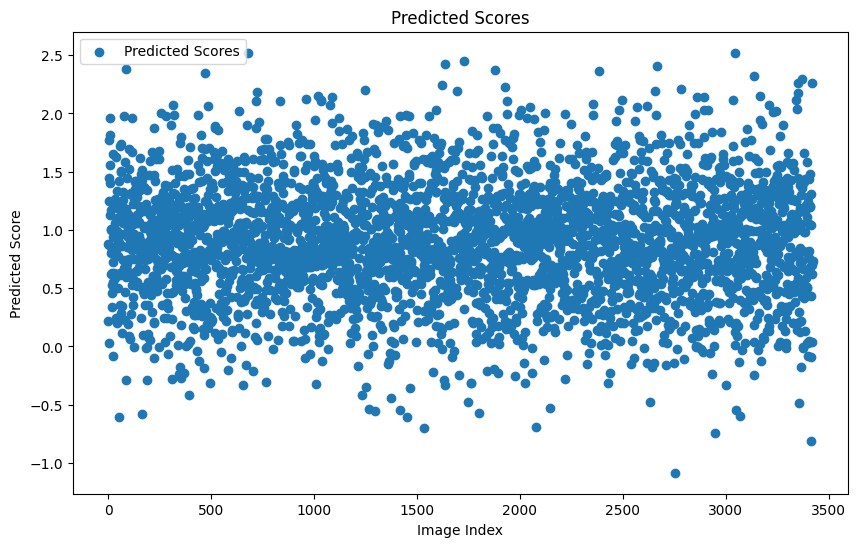

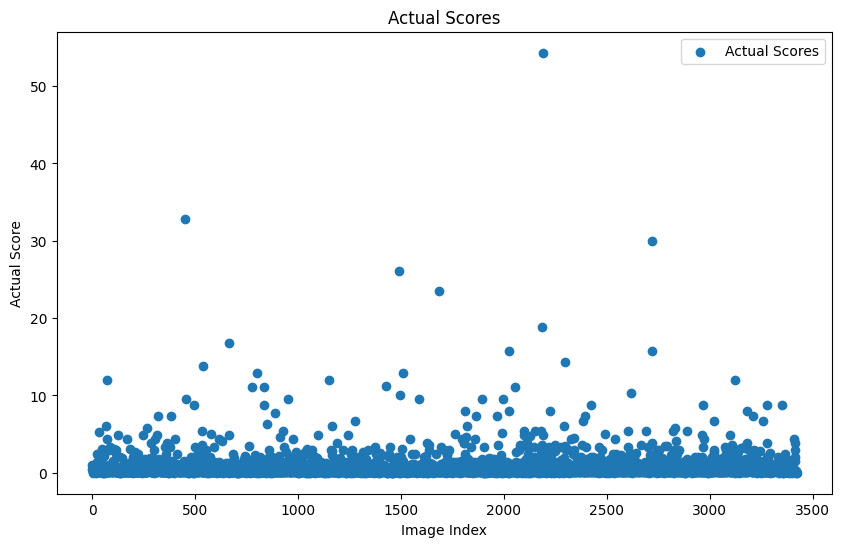

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the predicted_scores list to a numpy array
predicted_scores = np.array(predicted_scores)

# Convert the target scores to a numpy array
actual_scores = np.array(test_scores)

# Plotting the predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.xlabel('Image Index')
plt.ylabel('Predicted Score')
plt.title('Predicted Scores')
plt.legend()
plt.show()

# Plotting the actual scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Actual Score')
plt.title('Actual Scores')
plt.legend()
plt.show()


In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_maps(model, input_image, layer_index):
    # Create a forward hook to capture the output of the desired layer
    activations = []
    def hook(module, input, output):
        activations.append(output.detach())
    target_layer = list(model.children())[layer_index]
    hook_handle = target_layer.register_forward_hook(hook)

    # Add a batch dimension to the input image tensor
    input_image = input_image.unsqueeze(0)

    # Pass the input image through the model
    model.eval()
    with torch.no_grad():
        output = model(input_image)

    # Extract the feature maps from the captured activations
    feature_maps = activations[0]

    # Visualize the feature maps
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))

    # Denormalize and plot each feature map
    for i in range(num_maps):
        feature_map = feature_maps[0, i].cpu().numpy()
        feature_map = (feature_map - np.min(feature_map)) / (np.max(feature_map) - np.min(feature_map))  # Normalize to [0, 1]
        axes[i].imshow(feature_map)
        axes[i].axis('off')

    # Clean up the hook
    hook_handle.remove()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming you have the trained model and an input image tensor
trained_model = model
input_image = images[5]  # Replace with your input image tensor

# Visualize the feature maps from the first convolutional layer (layer index 0)
visualize_feature_maps(trained_model, input_image, 0)


IndexError: index 5 is out of bounds for dimension 0 with size 4

In [ ]:
import torch
import torch.nn as nn

def visualize_features(model, chosen_neuron, num_iterations=100, lr=0.1):
    # Set the model in evaluation mode
    model.eval()

    # Generate a random input image or initialize with noise
    input_image = torch.randn(1, 3, 224, 224)  # Adjust the shape and dimensions according to your input

    # Move the input image to the same device as the model
    device = next(model.parameters()).device
    input_image = input_image.to(device)

    # Set the requires_grad flag of the input image tensor to True
    input_image.requires_grad = True

    # Optimization loop
    for _ in range(num_iterations):
        # Forward pass
        output = model(input_image)

        # Compute the gradient of the output score with respect to the input image
        loss = output[0, chosen_neuron]  # Assuming output is a tensor of shape (1, num_neurons)
        loss.backward()

        # Update the input image by adding a fraction of the gradient
        with torch.no_grad():
            input_image += lr * input_image.grad

            # Reset the gradient
            input_image.grad.zero_()

    # Convert the input image tensor back to numpy array for visualization
    input_image = input_image.detach().cpu().numpy()

    # Visualize the input image
    # ... Add your visualization code here ...


In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
data_iter = iter(train_loader)
images, scores = next(data_iter)

# Select the first image from the batch
image = images[0]

# Print the shape and other information about the image
print("Image shape:", image.shape)
print("Image tensor:", image)


Image shape: torch.Size([3, 224, 224])
Image tensor: tensor([[[-0.6965, -0.6965, -0.6965,  ..., -0.7822, -0.7822, -0.7822],
         [-0.6965, -0.6965, -0.6794,  ..., -0.7822, -0.7822, -0.7822],
         [-0.6794, -0.6794, -0.6794,  ..., -0.7822, -0.7822, -0.7822],
         ...,
         [-1.6555, -1.6555, -1.7583,  ..., -1.7754, -1.4158, -1.5870],
         [-1.5185, -1.4843, -1.5699,  ..., -1.9809, -1.4672, -1.8953],
         [-1.8439, -1.7412, -1.7412,  ..., -1.9638, -1.2788, -1.8782]],

        [[ 0.9055,  0.9055,  0.9055,  ...,  0.8179,  0.8179,  0.8179],
         [ 0.9055,  0.9055,  0.9230,  ...,  0.8179,  0.8179,  0.8179],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.8179,  0.8179,  0.8179],
         ...,
         [-1.5105, -1.5105, -1.6331,  ..., -1.5280, -1.1604, -1.3354],
         [-1.3880, -1.3529, -1.4405,  ..., -1.6681, -1.1604, -1.5980],
         [-1.7206, -1.6155, -1.6155,  ..., -1.6506, -0.9503, -1.5630]],

        [[ 2.5703,  2.5703,  2.5703,  ...,  2.6051,  2.6051,  2

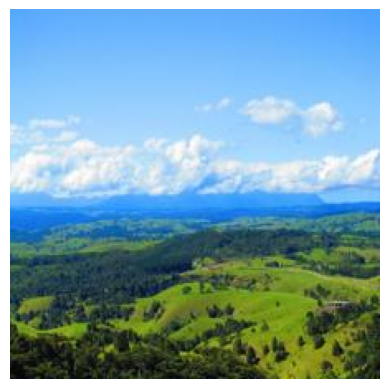

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the image tensor to a numpy array
image_np = image.numpy()

# Transpose the array to match the channel, height, width format
image_np = np.transpose(image_np, (1, 2, 0))

# Denormalize the image by multiplying with the standard deviation and adding the mean
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean

# Clip the pixel values to the valid range of 0-1
image_np = np.clip(image_np, 0, 1)

# Display the image
plt.imshow(image_np)
plt.axis('off')
plt.show()


#### Optimize with Resnet

Iteration [0/1000], Score: -0.2948
Iteration [100/1000], Score: 2.0406
Iteration [200/1000], Score: 2.4720
Iteration [300/1000], Score: 2.7248
Iteration [400/1000], Score: 2.8220
Iteration [500/1000], Score: 2.9785
Iteration [600/1000], Score: 3.1072
Iteration [700/1000], Score: 3.1331
Iteration [800/1000], Score: 3.2438
Iteration [900/1000], Score: 3.2894


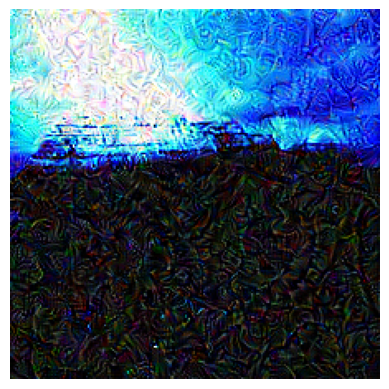

In [88]:
import torch.optim as optim
import torchvision.models as models

def optimize_image(image, model, score_target, learning_rate, num_iterations):
    image = image.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([image], lr=learning_rate)

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        output = model(image)
        score = output.squeeze()  # Assuming the model output is a single score
        loss = -score  # We want to maximize the score, so negate it
        loss.backward()
        optimizer.step()

        # Clamp the image pixel values to a valid range (e.g., 0-1 for normalized images)
        image.data.clamp_(0, 1)

        if iteration % 100 == 0:
            print('Iteration [{}/{}], Score: {:.4f}'.format(iteration, num_iterations, score.item()))

        # Check if the desired score target is reached
        if score >= score_target:
            break

    return image

# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth", map_location=torch.device('cpu')))

# Assuming you already have the transformed image tensor
sample_image = transformed_images[0]  # Use your own image here

# Reshape the sample_image tensor to have 4 dimensions
sample_image = sample_image.unsqueeze(0)

# Set the desired target score for optimization
score_target = 10.0  # Adjust this value based on your requirements

# Set the hyperparameters for optimization
learning_rate = 0.01
num_iterations = 1000

# Perform image optimization
optimized_image = optimize_image(sample_image, model, score_target, learning_rate, num_iterations)

# Visualize the optimized image
import matplotlib.pyplot as plt
plt.imshow(optimized_image.squeeze().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()


Iteration [0/1000], Score: -0.2891
Iteration [100/1000], Score: 2.1094
Iteration [200/1000], Score: 2.5395
Iteration [300/1000], Score: 2.7102
Iteration [400/1000], Score: 2.8546
Iteration [500/1000], Score: 2.9686
Iteration [600/1000], Score: 3.0758
Iteration [700/1000], Score: 3.0673
Iteration [800/1000], Score: 3.2051
Iteration [900/1000], Score: 3.2622


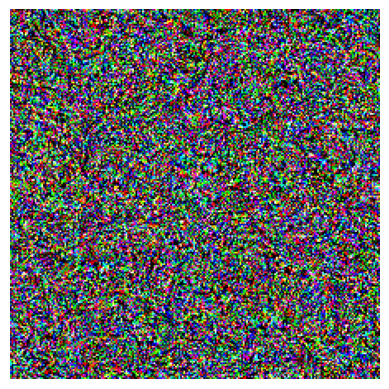

In [89]:
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

def optimize_image(model, score_target, learning_rate, num_iterations):
    image = torch.randn(1, 3, 224, 224)  # Initialize with random values
    image = image.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([image], lr=learning_rate)

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        output = model(image)
        score = output.squeeze()  # Assuming the model output is a single score
        loss = -score  # We want to maximize the score, so negate it
        loss.backward()
        optimizer.step()

        # Clamp the image pixel values to a valid range (e.g., 0-1 for normalized images)
        image.data.clamp_(0, 1)

        if iteration % 100 == 0:
            print('Iteration [{}/{}], Score: {:.4f}'.format(iteration, num_iterations, score.item()))

        # Check if the desired score target is reached
        if score >= score_target:
            break

    return image

# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth", map_location=torch.device('cpu')))

# Set the desired target score for optimization
score_target = 10.0  # Adjust this value based on your requirements

# Set the hyperparameters for optimization
learning_rate = 0.01
num_iterations = 1000

# Perform image optimization
optimized_image = optimize_image(model, score_target, learning_rate, num_iterations)

# Visualize the optimized image
import matplotlib.pyplot as plt
plt.imshow(optimized_image.squeeze().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()


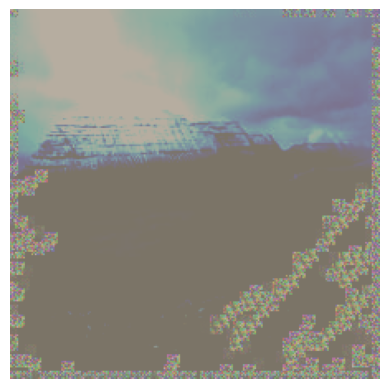

In [27]:

# Denormalize the image by multiplying with the standard deviation and adding the mean
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * optimized_image.squeeze().permute(1, 2, 0).detach().numpy() + mean

# Plot the denormalized image
plt.imshow(image_np)
plt.axis('off')
plt.show()


In [ ]:


# Create an instance of the model
model = Model().to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs and the batch size
num_epochs = 10
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 2000}")
            running_loss = 0.0

print("Training finished!")

In [ ]:
# Choose a random image without normalization
image = Image.open("{}/{}".format(image_path, "fl0b5.jpg"))

plt.imshow(image)
plt.show()

# Convert the image to a tensor without normalization
image_tensor = transforms.ToTensor()(image).unsqueeze(0)
img = image_tensor.clone().detach().requires_grad_(True)

# Set up the optimizer
optimizer = optim.Adam([img.requires_grad_()], lr=1e-2)

# Define the target output (near zero)
target = torch.tensor([[0]]).float()

# Run the optimization loop
tv_weight = 1e-6
for i in range(1000):
    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, target) + tv_weight * torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + tv_weight * torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    loss.backward()
    optimizer.step()
    
    # Clip the pixel values to stay within [0, 1] range
    img.data = torch.clamp(img.data, 0, 1)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print("Iteration {}: Loss={}".format(i, loss.item()))
        plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
        plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

### Predicting amount of upvotes

In [ ]:
# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Pass the image through the model
with torch.no_grad():
    output = model(input_tensor)

# Interpret the predicted output
predicted_upvotes = output.item()
print("Predicted upvotes:", predicted_upvotes)


### Feature highlighter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Set the model to evaluation mode and disable gradients
model.eval()
input_tensor.requires_grad_()

# Forward pass to obtain the output
output = model(input_tensor)

# Calculate the gradients of the output with respect to the input
output.backward()

# Get the gradients from the input tensor
gradients = input_tensor.grad[0]

# Convert the gradients to grayscale
grayscale_gradients = np.abs(gradients.numpy()).mean(axis=0)

# Normalize the gradients
normalized_gradients = (grayscale_gradients - np.min(grayscale_gradients)) / (
    np.max(grayscale_gradients) - np.min(grayscale_gradients)
)

# Plot the original image and the saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].axis('off')
axes[0].set_title('Input Image')
axes[1].imshow(normalized_gradients, cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')
plt.tight_layout()
plt.show()


Tanker vi kan køre på

Neural Style Transfer
To generate an image that carries over some of the features learned by the network, you can try a technique called "neural style transfer". Neural style transfer involves combining the style of one image with the content of another image using deep neural networks. This technique can be used to generate images that resemble a particular style, while still retaining some of the features of the original content.